In [2]:
import torch
import torchvision
from torchvision.transforms.functional import convert_image_dtype
from torchvision import tv_tensors
from torchvision.io import read_image
from tqdm.auto import tqdm
from warnings import filterwarnings
from matplotlib import font_manager, rc
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision.transforms import v2
filterwarnings('ignore')
font_path = "c:\WINDOWS\Fonts\GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', size=12) 

c:\Users\hyssk\anaconda3\envs\objectdetection\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 데이터 파이프라인


In [3]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from Dataset import TrashDataset
from torch.utils.data import DataLoader
from pathlib import Path
from torchvision.transforms import v2
from Dataloader import od_collate_fn
import torch
from warnings import filterwarnings
from tqdm.auto import tqdm

classes=['c_1','c_2_01','c_2_02','c_3',
         'c_4_01_02','c_4_02_01_02',
         'c_4_02_02_02','c_4_02_03_02','c_4_03','c_5_02',
         'c_6','c_7','c_1_01','c_2_02_01',
         'c_3_01','c_4_03_01','c_5_01_01',
         'c_5_02_01','c_6_01','c_7_01',
         'c_4_01_01','c_4_02_01_01',
         'c_4_02_02_01','c_4_02_03_01',
         'c_5_01','c_8_01','c_8_02',
         'c_8_01_01','c_9']

train_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224,224)),
    v2.RandomVerticalFlip(0.5)
])

test_transforms = v2.Compose([
    v2.Resize((224,224))
])

filterwarnings('ignore')

train_anno_path = Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Training\02.라벨링데이터')
train_img_dir = Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Training\01.원천데이터')

test_img_dir= Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Validation\01.원천데이터')
test_anno_path= Path(r'C:\Users\hyssk\MyThesisProject\307.생활폐기물 데이터 활용ㆍ환류\01-1.정식개방데이터\Validation\02.라벨링데이터')

train_dataset = TrashDataset(classes,train_anno_path,train_img_dir,train_transforms)
train_dataloader = DataLoader(train_dataset,2,True,collate_fn=od_collate_fn)

test_dataset = TrashDataset(classes,test_anno_path,test_img_dir,test_transforms)
test_dataloader = DataLoader(test_dataset,2,collate_fn=od_collate_fn)

# model 
num_classes = len(classes)+1
model_retinanet = retinanet_resnet50_fpn(num_classes =len(classes)+1, pretrained=False, pretrained_backbone = True)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 모델 학습

In [4]:
def train_step(model:torch.nn.Module,
              train_loader: torch.utils.data.DataLoader,
              optimizer: torch.optim):
    model.train()
    train_loss = 0.0
    for batch, target in tqdm(train_loader):
        batch = list(batch1.to(device) for batch1 in batch)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]
        loss_dict = model_retinanet(batch,target)
        loss = sum(v for v in loss_dict.values())
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss


def validation_step(model:torch.nn.Module,
              test_loader: torch.utils.data.DataLoader,
              optimizer: torch.optim):
    model.train()
    validation_loss = 0.0
    for batch, target in tqdm(test_loader):
        batch = list(batch1.to(device) for batch1 in batch)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]
        loss_dict = model_retinanet(batch,target)
        loss = sum(v for v in loss_dict.values())
        validation_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return validation_loss

In [5]:
optimizer=torch.optim.Adam(model_retinanet.parameters(),lr=0.0001)
model_retinanet.to(device)

train_losses = []
validation_losses =[]
for epochs in range(30):
    train_loss = train_step(model_retinanet,
               train_loader=train_dataloader,
               optimizer=optimizer)
    train_losses.append(train_loss.item())
    validation_loss=validation_step(model_retinanet,
                    test_dataloader,
                    optimizer=optimizer)
    validation_losses.append(validation_loss.item())
    

100%|██████████| 1687/1687 [05:26<00:00,  5.16it/s]


# 30 EPOCH 모델 저장

In [6]:
torch.save(model_retinanet.state_dict(),'best_model_retinanet_epoch_30_with_alpha.h5')

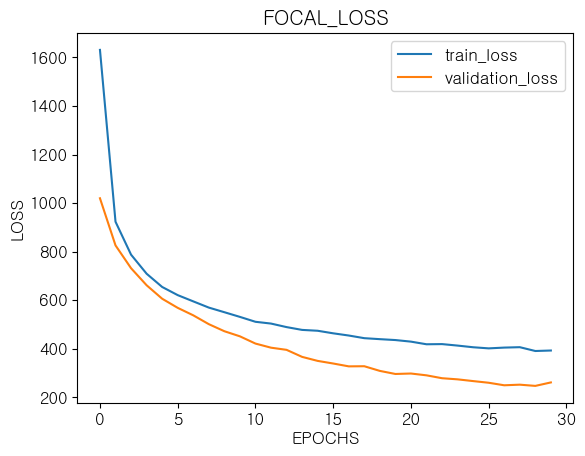

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses,label='train_loss')
plt.plot(validation_losses,label='validation_loss')
plt.ylabel('LOSS')
plt.xlabel("EPOCHS")
plt.legend()
plt.title("FOCAL_LOSS")
plt.show()

In [5]:
model_retinanet.load_state_dict(torch.load(r'C:\Users\hyssk\MyThesisProject\best_model_retinanet_epoch_30_with_alpha.h5'))

<All keys matched successfully>

# 모델에 이미지 넣고 예측한 BBOX PLOTING

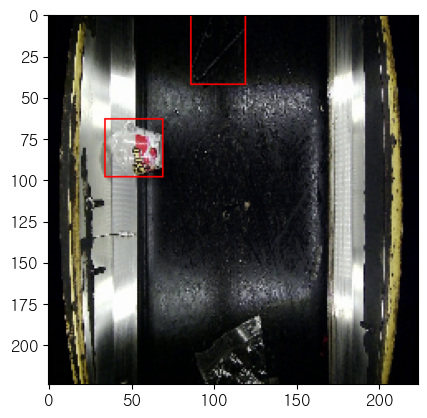

tensor([0.9712, 0.8071, 0.7914, 0.4340, 0.4085, 0.3036, 0.2352, 0.2231, 0.2136,
        0.2111, 0.1809, 0.1710, 0.1701, 0.1700, 0.1474, 0.1453, 0.1358, 0.1330,
        0.1248, 0.1168, 0.1167, 0.1155, 0.1143, 0.1139, 0.1107, 0.1071, 0.1054,
        0.1040, 0.1026, 0.1024, 0.0982, 0.0963, 0.0956, 0.0909, 0.0889, 0.0859,
        0.0852, 0.0843, 0.0812, 0.0806, 0.0764, 0.0749, 0.0749, 0.0744, 0.0737,
        0.0734, 0.0726, 0.0707, 0.0698, 0.0697, 0.0693, 0.0658, 0.0654, 0.0646,
        0.0636, 0.0636, 0.0610, 0.0610, 0.0608, 0.0602, 0.0595, 0.0585, 0.0568,
        0.0567, 0.0567, 0.0560, 0.0553, 0.0549, 0.0547, 0.0539, 0.0532, 0.0528,
        0.0526, 0.0520, 0.0512, 0.0507, 0.0505, 0.0501])
tensor([[ 86.9556,   0.5667, 119.1173,  42.9326],
        [ 34.6216,  63.5518,  69.1293,  98.6443]])


In [9]:
with torch.inference_mode():
    model_retinanet.eval()
    model_retinanet.to('cpu')
    img,_ = next(iter(test_dataloader))
    x = model_retinanet(img)

plt.figure()
plt.imshow(draw_bounding_boxes(convert_image_dtype(img[1],dtype= torch.uint8),x[1]['boxes'][x[1]['scores']>0.8],colors='red').permute(1,2,0))
plt.show()
print(x[1]['scores'])
print(x[1]['boxes'][x[1]['scores']>0.8])

# 내가 찍은 사진으로 예측해보기


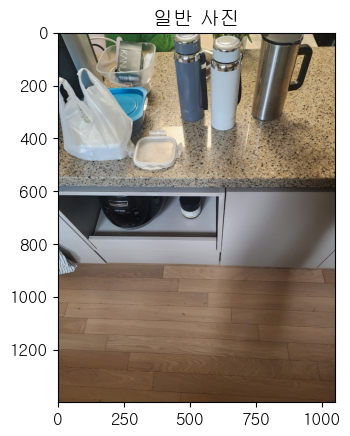

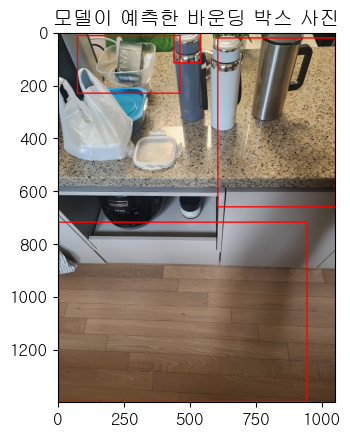

In [12]:
from torchvision.transforms import v2

transformed = v2.Compose([
    v2.ToTensor()
])
img = read_image(r'C:\Users\hyssk\MyThesisProject\sample.jpg')
transformed_img = transformed(img) / 255.0
plt.figure()
plt.title("일반 사진")
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

with torch.inference_mode(True):
    model_retinanet.eval()
    prediction = model_retinanet(transformed_img.unsqueeze(0))
plt.figure()
plt.title("모델이 예측한 바운딩 박스 사진")
plt.imshow(draw_bounding_boxes(convert_image_dtype(img,dtype= torch.uint8),prediction[0]['boxes'][prediction[0]['scores']>0.7],colors='red',width=5).permute(1,2,0))
plt.show()

ROBUST하지는 못한 단점이 존재

In [13]:
from torchmetrics.detection import MeanAveragePrecision

mAP = MeanAveragePrecision('xyxy')